# Neural network prediction for the sPOD-DL-ROM for CombustionWaveTA

In [1]:
import sys
sys.path.append('../DL/')
sys.path.append('../sPOD/lib/')
sys.path.append('../DL-ROM/LIB/')

In [2]:
from syntheticOnlyTA import syntheticOnlyTA
import numpy as np

/Users/shubhadityaburela/Python/sPOD-DL-ROM/tests/../sPOD/lib/farge_colormaps.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if type is 'vorticity':
/Users/shubhadityaburela/Python/sPOD-DL-ROM/tests/../sPOD/lib/farge_colormaps.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is 'pressure':
/Users/shubhadityaburela/Python/sPOD-DL-ROM/tests/../sPOD/lib/farge_colormaps.py:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is 'streamfunction':
/Users/shubhadityaburela/Python/sPOD-DL-ROM/tests/../sPOD/lib/farge_colormaps.py:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is 'velocity':


## Data generation / Shifted POD of the data

Check 1...
Relative time amplitude error for online prediction(interpolation) for num modes 5 is 0.0009265963425015743
Relative time amplitude error for online prediction(interpolation) for num modes 5 is 0.00098133537165524
Relative shift error for online prediction(interpolation) for num modes 5 is 6.901861674987081e-17
Relative shift error for online prediction(interpolation) for num modes 5 is 6.901861674987081e-17


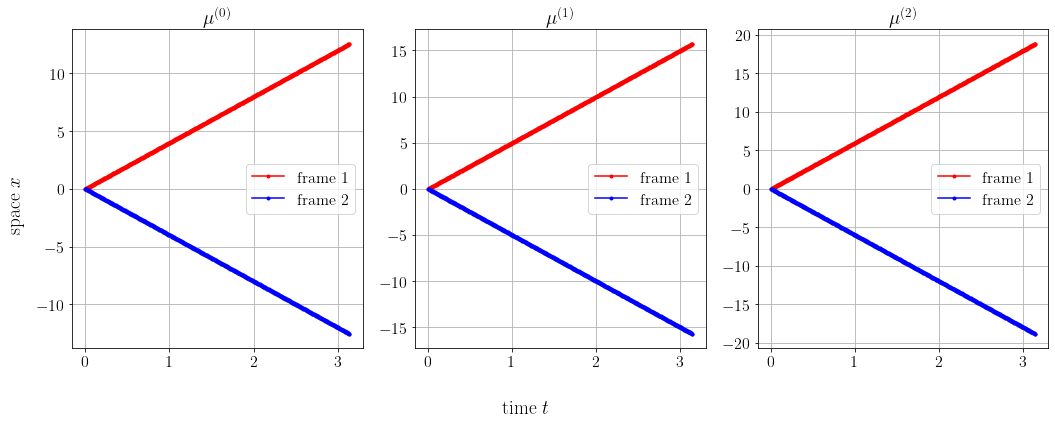

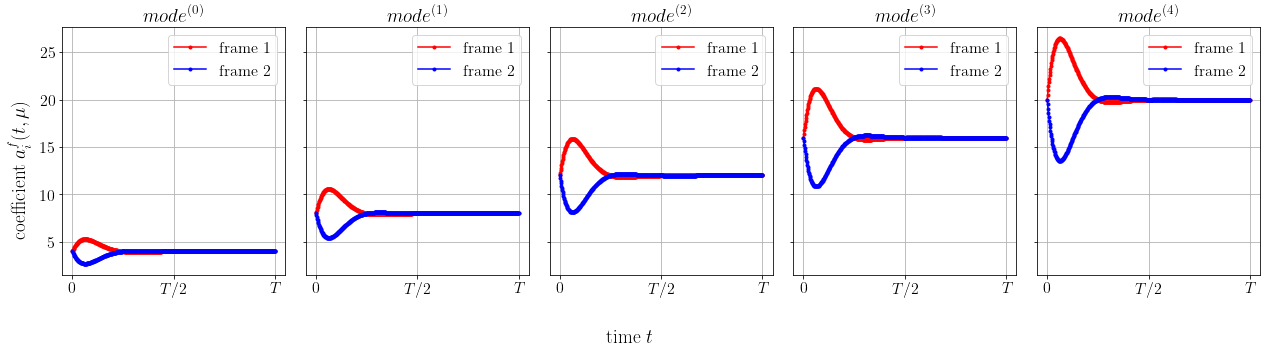

In [3]:
df = syntheticOnlyTA()        

## Input data for the network 

In [4]:
# We collect the time amplitudes, shifts and the parameters for the training as well as the testing data.
TA_TRAIN = df.TA_TRAIN
SHIFTS_TRAIN = df.SHIFTS_TRAIN
PARAMS_TRAIN = df.PARAMS_TRAIN
TA_TEST = df.TA_TEST
SHIFTS_TEST = df.SHIFTS_TEST
PARAMS_TEST = df.PARAMS_TEST

In [5]:
print("Grid, Nx : {}, Nt : {}".format(df.Nx, df.Nt))
print("Number of sPOD frames : {}".format(df.NumFrames))
print("Number of modes per frame : {}".format(df.nmodes))
print("Number of parameter instances : {}".format(int(int(TA_TRAIN.shape[1]) / df.Nt)))
print("Size of training matrix : {} x {}".format(int(TA_TRAIN.shape[0]), int(TA_TRAIN.shape[1])))

Grid, Nx : 500, Nt : 500
Number of sPOD frames : 2
Number of modes per frame : 5
Number of parameter instances : 3
Size of training matrix : 10 x 1500


In [6]:
# This cell is reserved for any data manipulations that need to be done for the network input
shifts_train = np.concatenate((np.reshape(SHIFTS_TRAIN[0], newshape=[1, -1]), np.reshape(SHIFTS_TRAIN[1], newshape=[1, -1])), axis=0)
shifts_test = np.concatenate((np.reshape(SHIFTS_TEST[0], newshape=[1, -1]), np.reshape(SHIFTS_TEST[1], newshape=[1, -1])), axis=0)

# Data manipulation for network input
ta_train = np.concatenate((TA_TRAIN, shifts_train), axis=0)
ta_test = np.concatenate((TA_TEST, shifts_test), axis=0)

## Network call

## Feed forward neural network

In [9]:
# Path for the pretrained weights
PATH = 'DNN_result/syntheticOnlyTA/training_results_sPOD/2022_08_24__18-32-23/trained_weights/weights.pt'

In [10]:
params = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': df.Nx,  # N_h
        'reduced_order_model_dimension': df.nmodes * df.NumFrames + df.NumFrames,  # N
        'totalModes': df.nmodes * df.NumFrames,  # Total number of modes for all the frames
        'NumOfFrames': df.NumFrames  # Total number of frames
    }

In [12]:
# training the model
from network import run_model 
print("#################################")
print("sPOD-DL-ROM")
trained_model, scaling = run_model(ta_train, PARAMS_TRAIN, epochs=100, lr=0.05, loss='L1',
                 logs_folder='./DNN_result/syntheticOnlyTA/training_results_sPOD',
                 pretrained_load=False, pretrained_weights=PATH, params=params)
print("#################################\n")

#################################
sPOD-DL-ROM
Average loss at epoch 0 on training set: 0.37257800499598187 and validation set: 0.7342322468757629
Relative evaluation error : 0.0733114
#################################



/opt/homebrew/Caskroom/miniforge/base/envs/PyTorch/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [13]:
# load the model
import torch
import pathlib
import os

log_folder_base = 'DNN_result/syntheticOnlyTA/training_results_sPOD'
log_folder_trained_model = sorted(pathlib.Path(log_folder_base).glob('*/'), key=os.path.getmtime)[-1]
PATH = str(log_folder_trained_model) + '/trained_weights/' + 'weights.pt'
print(PATH)

DNN_result/syntheticOnlyTA/training_results_sPOD/2022_11_24__14-16-37/trained_weights/weights.pt


In [14]:
from network import scale_params
PARAMS_TEST = scale_params(PARAMS_TEST, params, scaling)

In [16]:
# testing the model
from network import test_model 
rel_err, results_predicted = test_model(TA_TEST=ta_test, params_test=PARAMS_TEST, 
                                        saved_model=True, 
                                        PATH_TO_WEIGHTS=PATH, params=params, 
                                        scaling=scaling) 
print(rel_err)

0.946048


## Convolutional autoencoder and DNN coupled model

In [17]:
from TrainingFramework import TrainingFramework
from TestingFramework import TestingFramework
import Helper

In [18]:
dict_network = {
        'time_amplitude_train': ta_train,
        'time_amplitude_test': ta_test,
        'parameter_train': PARAMS_TRAIN,
        'parameter_test': PARAMS_TEST,
        'batch_size': 500,
        'num_early_stop': 1500,  # Number of epochs for the early stopping
        'pretrained_load': False,  # Whether to initialize the network with pretrained weights
        'scaling': False,  # true if the data should be scaled
        'perform_svd': 'randomized',  # '', 'normal', 'randomized'
        'learning_rate': 0.005,  # eta
        'full_order_model_dimension': df.Nx,  # N_h
        'reduced_order_model_dimension': df.nmodes * df.NumFrames + df.NumFrames,  # N
        'encoded_dimension': 4,  # dimension of the system after the encoder
        'omega_h': 0.8,
        'omega_N': 0.2,
        'typeConv': '1D',  # Type of convolutional layer for the network : '1D' or '2D'
        'totalModes': df.nmodes * df.NumFrames,  # Total number of modes for all the frames
        'NumOfFrames': df.NumFrames  # Total number of frames
    }

In [19]:
# select the path to the pre trained weights
PATH = 'CADNN_result/syntheticOnlyTA/training_results_sPOD/2022_08_23__19-55-17/net_weights/epoch_99.pt'

In [20]:
# Training model
train_model = TrainingFramework(dict_network, split=0.60, log_folder='./CADNN_result/syntheticOnlyTA/training_results_sPOD')
trained_model = train_model.training(epochs=100, save_every=50, print_every=50, 
                                     log_base_name='/', pretrained_weights=PATH)

DATA PREPARATION START...

DATA PREPARATION DONE ...

INPUT PIPELINE BUILD START ...

INPUT PIPELINE BUILD DONE ...

[INFO] epoch : 0...
[INFO] epoch : 1...
[INFO] epoch : 2...
[INFO] epoch : 3...
[INFO] epoch : 4...
[INFO] epoch : 5...
[INFO] epoch : 6...
[INFO] epoch : 7...
[INFO] epoch : 8...
[INFO] epoch : 9...
[INFO] epoch : 10...
[INFO] epoch : 11...
[INFO] epoch : 12...
[INFO] epoch : 13...
[INFO] epoch : 14...
[INFO] epoch : 15...
[INFO] epoch : 16...
[INFO] epoch : 17...
[INFO] epoch : 18...
[INFO] epoch : 19...
[INFO] epoch : 20...
[INFO] epoch : 21...
[INFO] epoch : 22...
[INFO] epoch : 23...
[INFO] epoch : 24...
[INFO] epoch : 25...
[INFO] epoch : 26...
[INFO] epoch : 27...
[INFO] epoch : 28...
[INFO] epoch : 29...
[INFO] epoch : 30...
[INFO] epoch : 31...
[INFO] epoch : 32...
[INFO] epoch : 33...
[INFO] epoch : 34...
[INFO] epoch : 35...
[INFO] epoch : 36...
[INFO] epoch : 37...
[INFO] epoch : 38...
[INFO] epoch : 39...
[INFO] epoch : 40...
[INFO] epoch : 41...
[INFO] epoc

In [21]:
import os
import pathlib

# Testing model
testing_method = ''

log_folder_base = 'CADNN_result/syntheticOnlyTA/training_results_sPOD/'
log_folder_trained_model = sorted(pathlib.Path(log_folder_base).glob('*/'), key=os.path.getmtime)[-1]

test_model = TestingFramework(dict_network)
test_model.testing(log_folder_trained_model=str(log_folder_trained_model), 
                   testing_method=testing_method, model=trained_model)
results_predicted = test_model.time_amplitude_test_output

## Online error analysis

In [22]:
# Data manipulation for error analysis
frame_amplitudes_predicted = results_predicted[:-2, :]
shifts_predicted = results_predicted[-2:, :]

#############################################
Online Error checks
Check 1...
Relative time amplitude error indicator for frame: 1 is 4.3399068111410495
Relative time amplitude error indicator for frame: 2 is 11.359115195011345
Check 2...
Relative error indicator for shift: 1 is 17.704701429864905
Relative error indicator for shift: 2 is 11.154643064508894


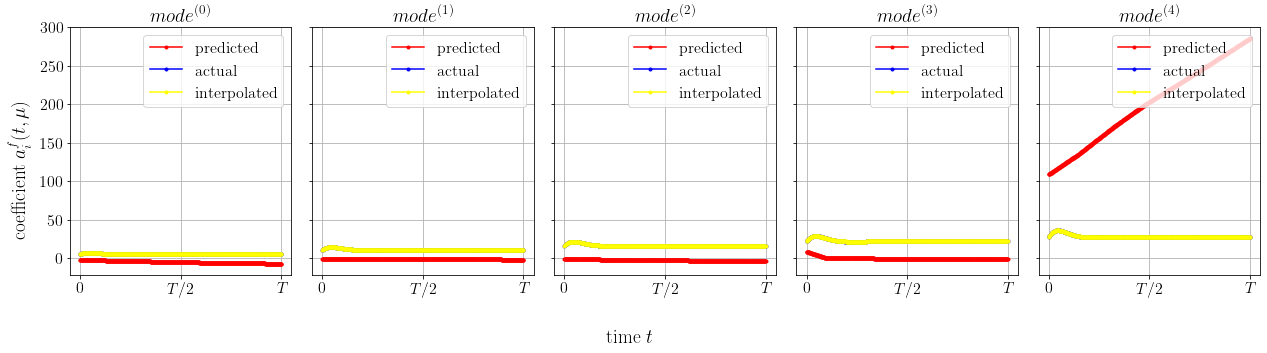

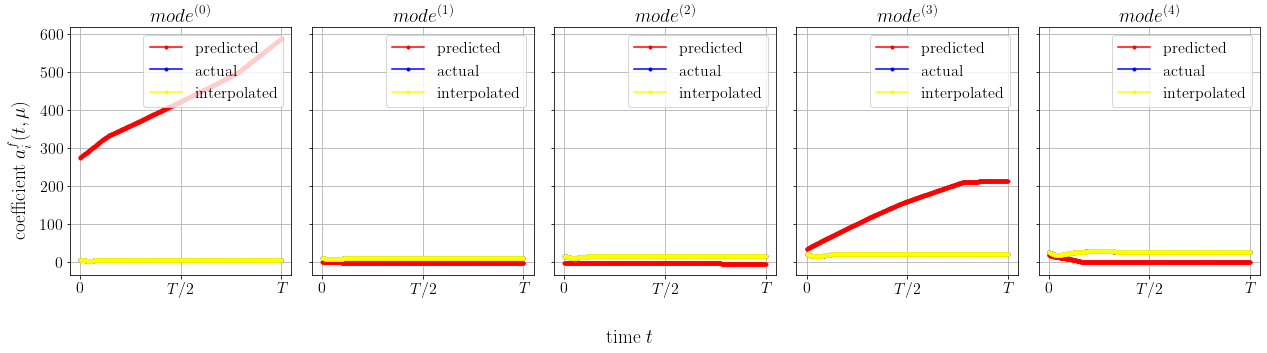

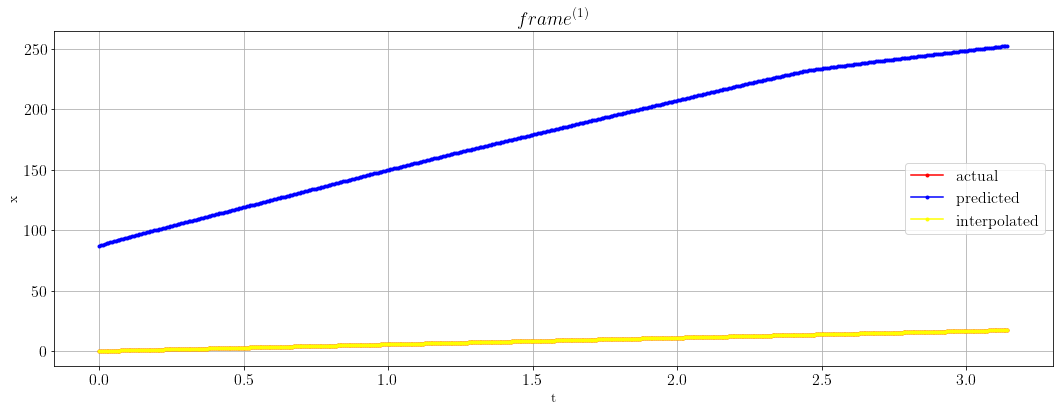

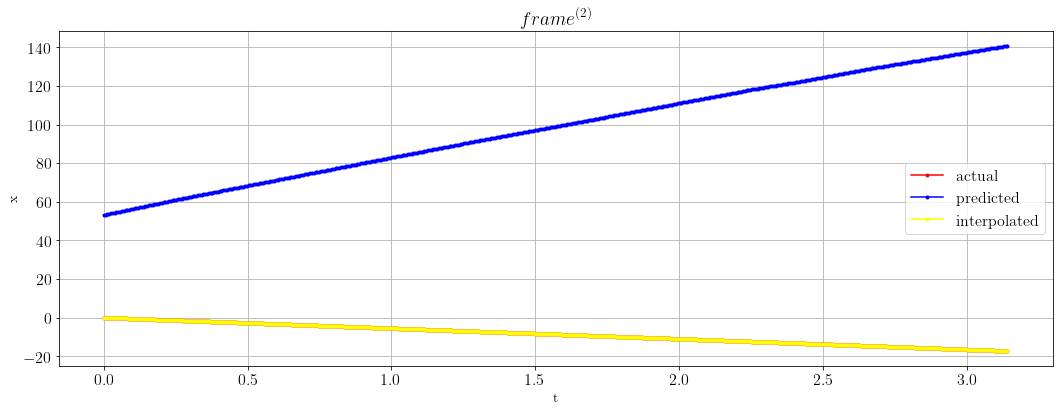

In [23]:
df.onlineErroranalysis(frame_amplitudes_predicted, shifts_predicted)